In [1]:
import sys
import importlib

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import numba

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

# Constants

In [2]:
collimator = dict(distance=250, angle=6, direction=60, number=306, todetector=4.37, diameter=1.5, interval=0.2, thickness=35)
detector = dict(number=128, width=4.0625, length=520, depth=9.5)
image = dict(pixels=128, width=4.0625)

In [3]:
x_pixels = np.arange(-image['pixels'] / 2 * image['width'] + image['width'] / 2, image['pixels'] / 2 * image['width'] + image['width'] / 2, image['width'])

In [4]:
X_pixels, Y_pixels = np.meshgrid(x_pixels, x_pixels)

In [5]:
x_pixels_wall = np.linspace(-image['pixels'] * image['width'] / 2, image['pixels'] * image['width'] / 2, image['pixels'] + 1)

y_pixels_wall = x_pixels_wall.copy()

pixels_wall = [x_pixels_wall, y_pixels_wall]

In [38]:
hotxy = np.array([[100, 0], [50, 86.6], [-50, 86.6], [-100, 0], [-50, -86.6], [50, -86.6]])

In [42]:
hotr = np.arange(8, 48 + 1, 8)

In [47]:
vali = [np.sqrt((X_pixels - hotxy[j][0]) ** 2 + (Y_pixels - hotxy[j][1]) ** 2) < hotr[j] for j in range(6)]
bkgvali = np.sqrt(X_pixels ** 2 + Y_pixels ** 2) < 15 * image['width']

# Transformation matrix

In [6]:
x_num = np.array([[1, image['pixels']]]).T

In [7]:
# @numba.njit
def sensitivity_map(t, pixels_wall):
    dim = len(t) // 2
    d = 0
    for j in range(dim):
        d += (t[j + dim] - t[j]) ** 2
    d = np.sqrt(d)
    d_frac = np.empty(0)
    dig_list = []
    dig_l = []
    for j, wall in enumerate(pixels_wall):
        x = [t[j], t[j+dim]]
        dig_list.append(np.digitize(x, wall))
        if dig_list[j][0] > dig_list[j][-1]:
            tl = np.arange(dig_list[j][-1], dig_list[j][0], 1)[::-1]
        else:
            tl = np.arange(dig_list[j][0], dig_list[j][-1], 1)
        dig_l.append(tl)
        x_list = pixels_wall[j][dig_l[j]]
        d_l = (x_list - t[j]) / (t[j+dim] - t[j]) * d
        d_frac = np.append(d_frac, d_l)
    x_init = np.array([[dig_list[j][0] - 1 for j in range(dim)]]).T
    ll = np.array([0])
    for j in range(dim):
        ll = np.append(ll, len(dig_l[j]))
    ll = np.cumsum(ll)
    int_list = np.zeros((dim, ll[-1])).astype(np.int16)
    for j in range(dim):
        if dig_list[j][0] > dig_list[j][-1]:
            int_list[j, ll[j]:ll[j+1]] = -1
        elif dig_list[j][0] < dig_list[j][-1]:
            int_list[j, ll[j]:ll[j+1]] = 1
    x_delta = int_list[:, d_frac.argsort()][:, :-1]
    x_cumdelta = np.zeros((dim, ll[-1] - 1)).astype(np.int16)
    for j in range(dim):
        x_cumdelta[j] = np.cumsum(x_delta[j])
    x_dig = x_init + x_cumdelta
    pixels_dig_xyz = x_dig * x_num
    pixels_dig = np.sum(pixels_dig_xyz, axis=0)
    vali = np.full(x_dig.shape[1], True)
    for j, wall in enumerate(pixels_wall):
        vali &= ((x_dig[j] >= 0) & (x_dig[j] < len(wall) - 1))
    return pixels_dig[vali], np.diff(np.sort(d_frac))[vali], 

In [8]:
mu = 0.1538 * 1 #cm-1

In [9]:
def trans_matrix(method='delta'):
    matrix = np.zeros((detector['number'] * collimator['direction'], image['pixels'] ** 2))#.astype(np.float32)
    distance = collimator['distance'] + collimator['todetector'] + collimator['thickness']
    if method == 'delta':
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            t_c = np.arange(-detector['number'] / 2 * detector['width'], detector['number'] / 2 * detector['width'] + 1e-8, detector['width'])
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_c = np.cos(theta + np.pi / 2) * t_c + x_o
            y_c = np.sin(theta + np.pi / 2) * t_c + y_o
            b = y_c - k * x_c
            slit = np.digitize(Y_pixels.flatten() - k * X_pixels.flatten(), b) - 1
            # slit = slit[(slit >= 0) & (slit < detector['number'])]
            # idx, count = np.unique(slit, return_counts=True)
            for j, s in enumerate(slit):
                if s >= 0 and s < detector['number']:
                    m[s, j] = 1
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    elif method == 'Siddon':
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_i = np.cos(theta + np.pi / 2) * x_pixels
            y_i = np.sin(theta + np.pi / 2) * x_pixels
            x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
            y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
            x_d = 2 * x_i - x_c
            y_d = 2 * y_i - y_c
            xy = np.vstack([x_c, y_c, x_d, y_d]).T
            for j, xyi in enumerate(xy):
                idx, d = sensitivity_map(xyi, pixels_wall)
                m[j, idx] = d
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    elif method == 'Siddon-decay':
        width = 2 * detector['number'] * detector['width']
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_i = np.cos(theta + np.pi / 2) * x_pixels
            y_i = np.sin(theta + np.pi / 2) * x_pixels
            x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
            y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
            x_d = 2 * x_i - x_c
            y_d = 2 * y_i - y_c
            xy = np.vstack([x_c, y_c, x_d, y_d]).T
            for j, xyi in enumerate(xy):
                idx, s = sensitivity_map(xyi, pixels_wall)
                d = np.sqrt((X_pixels - xyi[0]) ** 2 + (Y_pixels - xyi[1]) ** 2).flatten()
                # m[j, idx] = s * np.exp(-d[idx] / 10 * mu) * 10
                m[j, idx] = s * (width - d[idx]) / width
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    elif method == 'Siddon-vague':
        width = 2 * detector['number'] * detector['width']
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            x_o = np.cos(theta) * distance
            y_o = np.sin(theta) * distance
            x_i = np.cos(theta + np.pi / 2) * x_pixels
            y_i = np.sin(theta + np.pi / 2) * x_pixels
            x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
            y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
            x_d = 2 * x_i - x_c
            y_d = 2 * y_i - y_c
            xy = np.vstack([x_c, y_c, x_d, y_d]).T
            for j, xyi in enumerate(xy):
                idx, s = sensitivity_map(xyi, pixels_wall)
                m[j, idx] += s
                d = np.sqrt((X_pixels - xyi[0]) ** 2 + (Y_pixels - xyi[1]) ** 2).flatten()
                if j - 1 >= 0:
                    idx, s = sensitivity_map(xy[j-1], pixels_wall)
                    m[j-1, idx] += s * d[idx] / width
                if j + 1 < len(xy):
                    idx, s = sensitivity_map(xy[j+1], pixels_wall)
                    m[j+1, idx] += s * d[idx] / width
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    return matrix

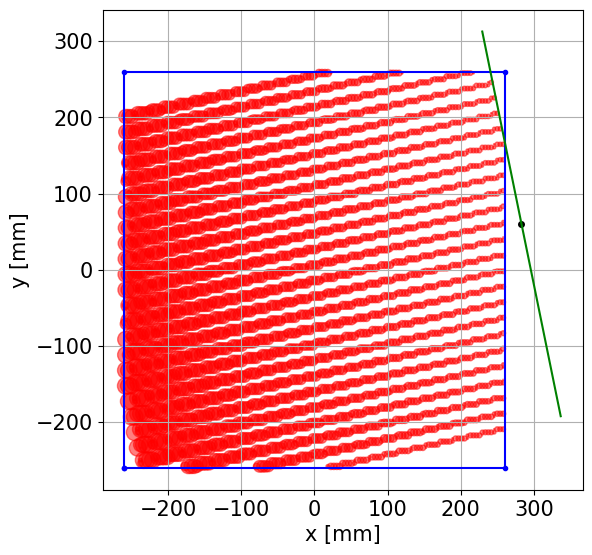

In [23]:
m = trans_matrix(method='Siddon-vague')

distance = collimator['distance'] + collimator['todetector'] + collimator['thickness']

fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
mmin = m[2 * detector['number']:3 * detector['number'], :][m[2 * detector['number']:3 * detector['number'], :] != 0].min()
mmax = (m[2 * detector['number']:3 * detector['number'], :] / mmin).max()
for j in np.arange(2 * detector['number'], 3 * detector['number'], 5):
    ax.scatter(X_pixels.flatten(), Y_pixels.flatten(), c='r', s=(np.exp(m[j, :] / mmin / mmax * 5) - 1), alpha=0.5)
d = detector['number'] * detector['width']
theta = 2 * collimator['angle'] / 180 * np.pi + 1e-8
ax.plot([-d/2, -d/2, d/2, d/2, -d/2], [-d/2, d/2, d/2, -d/2, -d/2], '.-', color='b')
t_c = np.arange(-detector['number'] / 2 * detector['width'], detector['number'] / 2 * detector['width'] + 1e-8, detector['width'])
x_o = np.cos(theta) * distance
y_o = np.sin(theta) * distance
x_i = np.cos(theta + np.pi / 2) * x_pixels
y_i = np.sin(theta + np.pi / 2) * x_pixels
x_c = np.cos(theta + np.pi / 2) * x_pixels + x_o
y_c = np.sin(theta + np.pi / 2) * x_pixels + y_o
x_d = 2 * x_i - x_c
y_d = 2 * y_i - y_c
ax.plot(x_c, y_c, c='g')
# ax.plot(x_d, y_d, c='g')
ax.scatter(x_o, y_o, c='k', s=16.)
ax.grid()
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

plt.show()

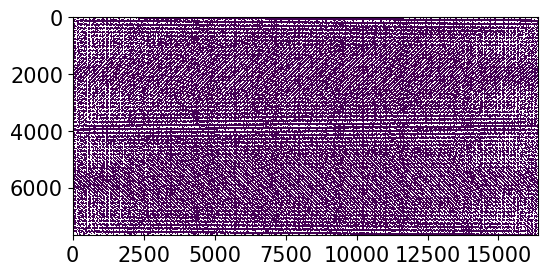

In [63]:
method = 'delta'
method = 'Siddon'

m = trans_matrix(method='Siddon')

plt.imshow(m, norm=LogNorm(vmin=0.5, vmax=2.0))
plt.show()

# ML-EM reconstruction

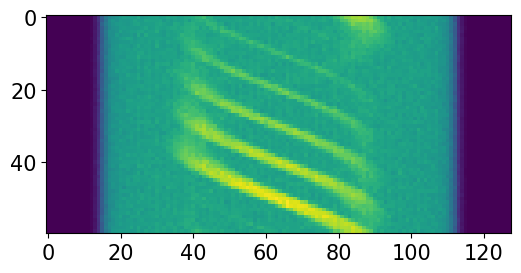

In [64]:
p = np.fromfile('Proj_1e7Counts', dtype=np.float32)

plt.imshow(p.reshape((collimator['direction'], image['pixels'])))
plt.show()

In [65]:
f = np.full(image['pixels'] ** 2, p.sum() / m.sum()).astype(np.float32)
f_list = [f]
d_list = []

for i in tqdm(range(200)):
    f_t = f_list[-1] / m.sum(axis=0) * (m.T @ (p / (m @ f_list[-1])))
    f_list.append(f_t)
    d_list.append(np.abs(f_list[-2] - f_list[-1]).max())
    if d_list[-1] < 1e-3:
        break

100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


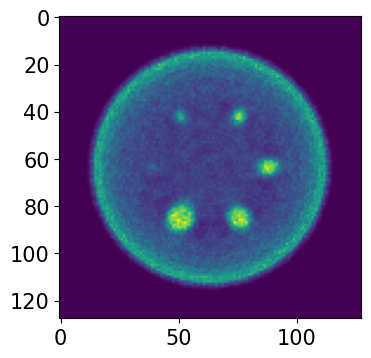

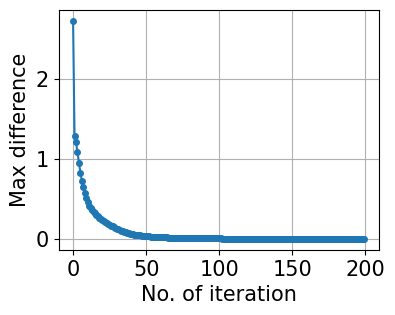

In [66]:
gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]
plt.imshow(gray[::-1, ::-1])
plt.show()

fig = plt.figure(figsize=(4, 3))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
# ax.scatter(np.arange(len(d_list)), d_list, s=2.0)
ax.plot(np.arange(len(d_list)), d_list, 'o-', markersize=4.0)
ax.grid()
ax.set_xlabel('No. of iteration')
ax.set_ylabel('Max difference')

plt.show()

In [67]:
gray.astype('float32').tofile('result')

# OS-EM reconstruction

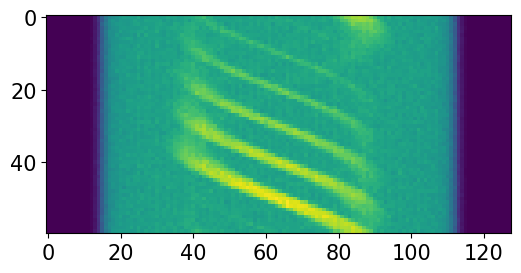

In [68]:
p = np.fromfile('Proj_1e7Counts', dtype=np.float32)

plt.imshow(p.reshape((collimator['direction'], image['pixels'])))
plt.show()

In [69]:
L_list = np.array([1, 2, 4, 6, 10, 15, 30])
L = L_list[3]

f = np.full(m.shape[1], p.sum() / m.sum())
f_list = [f]
d_list = []
tiny = np.finfo(np.float32).tiny
D = m.shape[0] // L

for i in tqdm(range(50)):
    for j in range(L):
        f_t = f_list[-1] / (m[D*j:D*(j+1), :].sum(axis=0) + tiny) * (m[D*j:D*(j+1), :].T @ (p[D*j:D*(j+1)] / (m[D*j:D*(j+1), :] @ f_list[-1] + tiny)))
        f_list.append(f_t)
        d_list.append(np.abs(f_list[-2] - f_list[-1]).max())
        # if d_list[-1] < 1e-3:
        #     break

100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


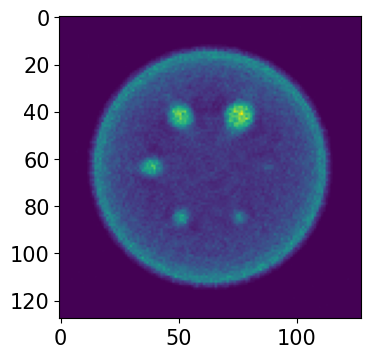

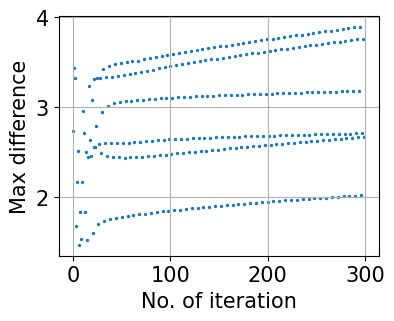

In [70]:
gray = f_list[-1].reshape((image['pixels'], image['pixels']))[::-1, ::-1]
plt.imshow(gray)
plt.show()

fig = plt.figure(figsize=(4, 3))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(np.arange(len(d_list)), d_list, s=2.0)
# ax.plot(np.arange(len(d_list)), d_list, 'o-', markersize=4.0)
ax.grid()
ax.set_xlabel('No. of iteration')
ax.set_ylabel('Max difference')

plt.show()

<ipython-input-71-3d446d654eb4>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(X_pixels, Y_pixels, gray)


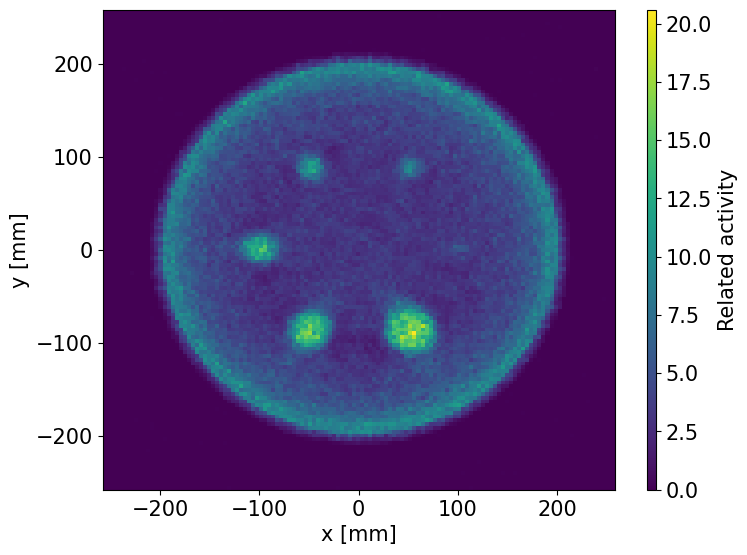

In [71]:
fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
p = ax.pcolormesh(X_pixels, Y_pixels, gray)
c = fig.colorbar(p, ax=ax, aspect=50)
c.ax.set_ylabel('Related activity')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

plt.show()

In [72]:
gray.astype('float32').tofile('result')

In [73]:
[vali[j].sum() for j in range(6)]

[14, 49, 110, 194, 303, 435]

In [74]:
C = 5

CRC = [(gray[vali[j]].mean() - gray[bkgvali].mean()) / gray[vali[j]].mean() / (C - 1) for j in range(6)]

CNR = [(gray[vali[j]].mean() - gray[bkgvali].mean()) / gray[vali[j]].std() for j in range(6)]